In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score, RocCurveDisplay
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

In [3]:
df2 = pd.read_csv('/content/drive/MyDrive/Dissertation/clean_diabetes_data.csv')

with open('/content/drive/MyDrive/Dissertation/clean_label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

with open('/content/drive/MyDrive/Dissertation/clean_feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

print("Clean dataset loaded: ", df2.shape)
print("Features: ", len(feature_names))
print("Classes: ", len(label_encoder.classes_))

Clean dataset loaded:  (70000, 39)
Features:  38
Classes:  13


In [4]:
X = df2[feature_names]
y = df2['diabetes_type']
y_encoded = label_encoder.transform(y)

y.value_counts()

,count
diabetes_type,
mody,5553
secondary diabetes,5479
cystic fibrosis-related diabetes (cfrd),5464
type 1 diabetes,5446
neonatal diabetes mellitus (ndm),5408
wolcott-rallison syndrome,5400
type 2 diabetes,5397
prediabetic,5376
gestational diabetes,5344


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Training: ", len(X_train), "samples (60%)")
print("Validation: ", len(X_val), "samples (20%)")
print("Test: ", len(X_test), "samples (20%)")

Training:  42000 samples (60%)
Validation:  14000 samples (20%)
Test:  14000 samples (20%)


In [6]:
# Hyperparameter Tuning
param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.1],
    'n_estimators': [100],
    'reg_alpha': [0]
}

# Using 3-fold cross-validation to save time
cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb_model = xgb.XGBClassifier(random_state=42)

grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    cv=cv_folds,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

best_model = grid_search.best_estimator_

Best parameters:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0}
Best cross-validation score: 0.906


In [7]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

print("Number of classes: ", best_model.n_classes_)
print("Number of features: ", best_model.n_features_in_)

Number of classes:  13
Number of features:  38


In [8]:
# Evaluating model performance on validation set
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Validation accuracy: {val_accuracy:.3f}")

if val_accuracy > 0.75:
    print("Good model performance")
else:
    print("Model performance could be improved")

Validation accuracy: 0.907
Good model performance


In [9]:
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Model Performance:")
print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Accuracy: {val_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

overfitting_gap = train_accuracy - test_accuracy
print(f"\nTrain-Test Gap: {overfitting_gap:.3f}")

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='macro')

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

Model Performance:
Training Accuracy: 0.917
Validation Accuracy: 0.907
Test Accuracy: 0.905

Train-Test Gap: 0.013
Precision: 0.912
Recall: 0.905
F1-Score: 0.903


In [10]:
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

                                            precision    recall  f1-score   support

   cystic fibrosis-related diabetes (cfrd)       1.00      0.92      0.95      1093
                      gestational diabetes       0.89      0.96      0.92      1069
                                      lada       0.98      0.92      0.95      1045
                                      mody       0.97      0.83      0.90      1110
          neonatal diabetes mellitus (ndm)       1.00      1.00      1.00      1082
                               prediabetic       0.97      1.00      0.99      1075
                        secondary diabetes       0.79      0.80      0.79      1096
                  steroid-induced diabetes       0.81      0.87      0.84      1055
                           type 1 diabetes       0.85      1.00      0.92      1089
                           type 2 diabetes       0.97      0.65      0.78      1079
type 3c diabetes (pancreatogenic diabetes)       0.79      1.00      0.89  

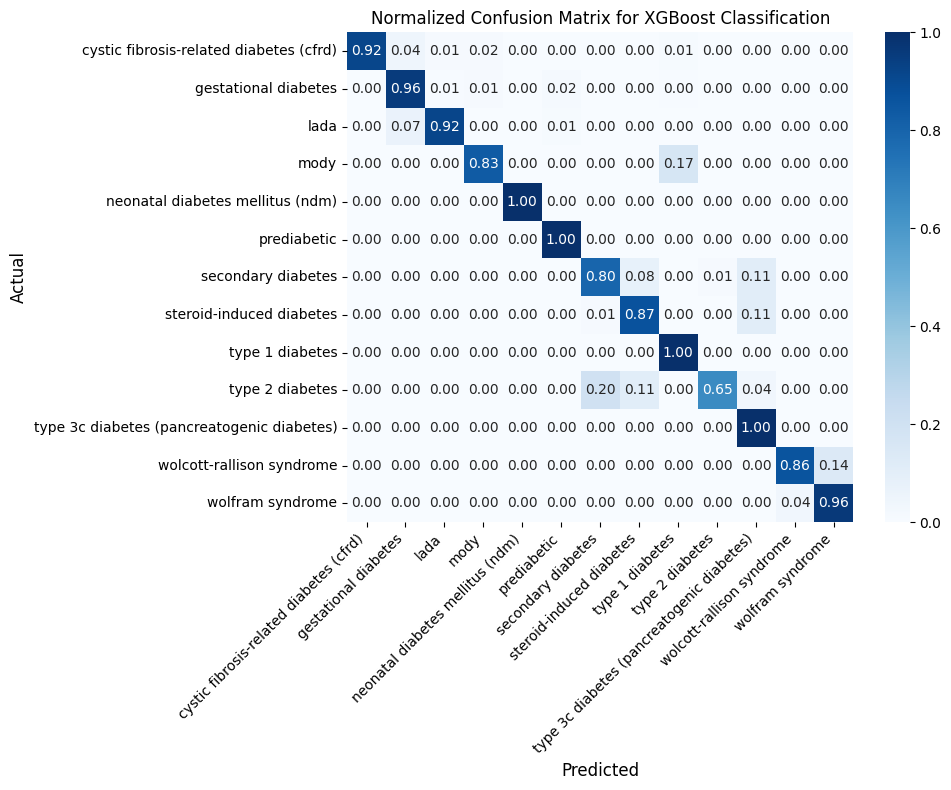

In [11]:
cm = confusion_matrix(y_test, y_test_pred, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Normalized Confusion Matrix for XGBoost Classification', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


Top 10 Most Important Features:
                     feature  importance
Weight Gain During Pregnancy       0.140
              Blood Pressure       0.132
        Blood Glucose Levels       0.121
                         Age       0.101
                Birth Weight       0.098
          Cholesterol Levels       0.063
                         BMI       0.062
         Waist Circumference       0.059
     Digestive Enzyme Levels       0.057
              Insulin Levels       0.046


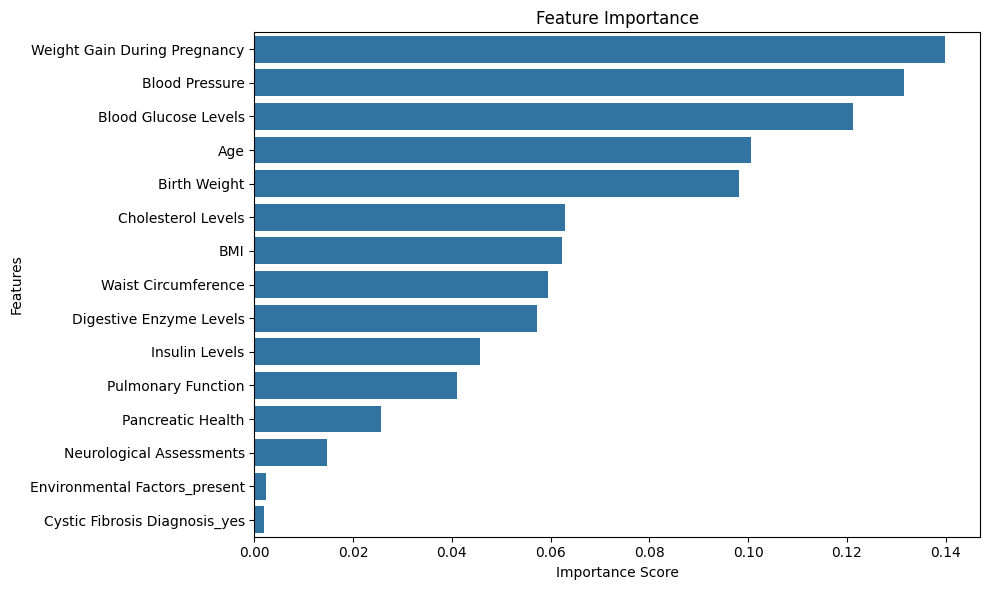

In [12]:
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False, float_format='%.3f'))

plt.figure(figsize=(10, 6))
top_features = importance_df.head(15)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [13]:
y_test_pred_proba = best_model.predict_proba(X_test)

AUC for Type 2 Diabetes: 0.992


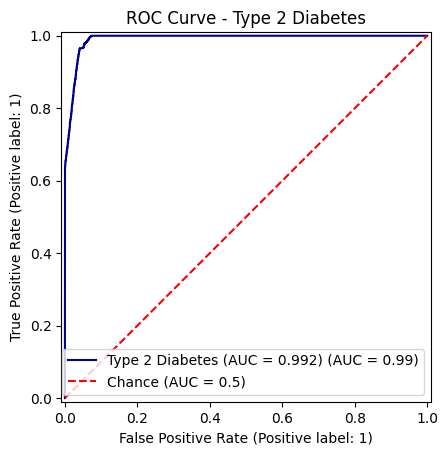

In [14]:
type2_idx = list(label_encoder.classes_).index("type 2 diabetes")

# 1=type 2, 0=else
y_test_binary = (y_test == type2_idx)
y_proba_type2 = best_model.predict_proba(X_test)[:, type2_idx]

auc_score = roc_auc_score(y_test_binary, y_proba_type2)
print(f"AUC for Type 2 Diabetes: {auc_score:.3f}")

RocCurveDisplay.from_predictions(y_test_binary, y_proba_type2,
                                 name=f"Type 2 Diabetes (AUC = {auc_score:.3f})",
                                 color="darkblue")
plt.plot([0, 1], [0, 1], "r--", label="Chance (AUC = 0.5)")
plt.title("ROC Curve - Type 2 Diabetes")
plt.legend(loc="lower right")
plt.show()

In [15]:
with open('/content/drive/MyDrive/Dissertation/xgboost_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('/content/drive/MyDrive/Dissertation/xgboost_feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

with open('/content/drive/MyDrive/Dissertation/xgboost_label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

results = {
    'test_accuracy': test_accuracy,
    'validation_accuracy': val_accuracy,
    'train_accuracy': train_accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'best_params': grid_search.best_params_,
    'n_features': len(feature_names),
    'n_classes': len(label_encoder.classes_)
}

with open('/content/drive/MyDrive/Dissertation/xgboost_model_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Model and results saved successfully")

Model and results saved successfully
